In [15]:
!pip3 install openpyxl


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import os
import math
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
import random
import time
import psutil
import os
import csv

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [ ]:
def start_resource_tracking():
    process = psutil.Process(os.getpid())
    start_time = time.time()
    start_memory = process.memory_info().rss # Returned in bytes
    return process, start_time, start_memory

In [ ]:
def end_resource_tracking(process, start_time, start_memory):
    end_time = time.time()
    end_memory = process.memory_info().res
    elapsed_time = end_time - start_time
    memory_used = (end_memory - start_memory) / (1024 * 1024)

    print(f'\nResource Consumption Report:')
    print(f'Elapsed Time: {elapsed_time: .2f} seconds')
    print(f'Memory Change: {memory_used: .2f} MBs') #If negative, memory freed


    #CPU usage
    cpu_usage = process.cpu_percent(interval = 1.0)
    print(f'CPU Usage: {cpu_usage: .2f} (approximately)')

In [18]:
class TemporalDataset(Dataset):
    def __init__(self, root_dir, sub_folder, transform, data_type='train', sequence_length=50):
        
        self.root_dir = root_dir
        self.sub_folder = sub_folder
        self.transform = transform
        self.data_type = data_type
        self.sequence_length = sequence_length
        self.image_paths = []
        self.labels = []

        # Load appropriate data
        self.load_data()

    def load_data(self):
        # Choose the correct label file based on data type -> doing this to prevent any data leakage through labels
        label_file = (
            os.path.join(self.root_dir, 'shortaxis_binary v2.xlsx')
            if self.data_type == 'train'
            else os.path.join(self.root_dir, 'new image frames.xlsx')
        )

        num_videos = 0
        for video_folder in os.listdir(os.path.join(self.root_dir, self.sub_folder)):
            if os.path.isdir(os.path.join(self.root_dir, self.sub_folder, video_folder)):
                video_path = os.path.join(self.root_dir, self.sub_folder, video_folder)
                try:
                    labels_df = pd.read_excel(label_file, sheet_name=video_folder)
                    print(f"Processing video folder: {video_folder}")
                    num_videos += 1
                except ValueError:
                    continue

                for img_filename in os.listdir(video_path):
                    if img_filename.endswith(".jpg"):
                        img_path = os.path.join(video_path, img_filename)
                        try:
                            frame_idx = int(img_filename.split('_')[-1].split('.')[0])
                            labels = labels_df.loc[frame_idx, ['CORD', 'FLUID']].values.astype('float32')
                            self.image_paths.append(img_path)
                            self.labels.append(labels)
                        except KeyError:
                            print(f"Frame index {frame_idx} not found in {video_folder}, skipping.")
                            continue

        print(f"Number of videos processed: {num_videos}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
    

        if idx + self.sequence_length > len(self.image_paths):
            # If not enough frames, truncate the sequence to fit within bounds
            idx = len(self.image_paths) - self.sequence_length

        # Extract a sequence of images and labels
        image_sequence = []
        label_sequence = []
        for i in range(self.sequence_length):
            img_path = self.image_paths[idx + i]
            label = self.labels[idx + i]

            if not os.path.isfile(img_path):
                raise FileNotFoundError(f"Image file not found: {img_path}")

            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)

            image_sequence.append(image)
            label_sequence.append(label)

        # Stack images and labels into tensors
        image_sequence = torch.stack(image_sequence)
        label_sequence = torch.tensor(label_sequence, dtype=torch.float32)

        return image_sequence, label_sequence


In [19]:
class CNNLSTMSequenceClassifier(nn.Module):
    def __init__(self, num_classes, sequence_length, hidden_dim):
        super(CNNLSTMSequenceClassifier, self).__init__()
        self.sequence_length = sequence_length
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes

        # ResNet backbone
        self.resnet = resnet18(pretrained = True)
        self.resnet.fc = nn.Identity() 

        # Verify ResNet feature size
        dummy_input = torch.randn(1, 3, 224, 224)  # Batch size 1, 3 channels, 224x224 image
        resnet_feature_size = self.resnet(dummy_input).size(1)

        # LSTM for temporal processing
        self.lstm = nn.LSTM(input_size=resnet_feature_size, hidden_size=hidden_dim, num_layers=1, batch_first=True, dropout=0.2)

        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        batch_size, seq_len, c, h, w = x.size()

        # Reshape for ResNet processing
        x = x.view(batch_size * seq_len, c, h, w)  
        features = self.resnet(x)  # Extract features using ResNet
        features = features.view(batch_size, seq_len, -1)  # Reshaped for LSTM

        # LSTM for temporal feature extraction
        lstm_out, _ = self.lstm(features)
        last_hidden_state = lstm_out[:, -1, :]  # Use last hidden state for classification

        # Classification
        output = torch.sigmoid(self.fc(last_hidden_state))
        return output

In [20]:
def frame_contributions(rnn_out):
    frame_sums = torch.abs(rnn_out).sum(dim = 2)
    total_sum = frame_sums.sum(dim = 1, keepdim = True)
    contributions = frame_sums / total_sum
    return contributions


def train_temporal_model(train_loader, val_loader, model, criterion, optimizer, num_epochs):
  for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for sequences, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
      sequences, labels = sequences.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(sequences)

      # Loss calculation
      loss = criterion(outputs, labels[:, -1, :].squeeze(1))
      loss.backward()
      optimizer.step()
      train_loss += loss.item() * sequences.size(0)

      # Accuracy calculation
      preds = (outputs > 0.5).float()
      train_correct += (preds == labels[:, -1, :].squeeze(1)).sum().item()
      train_total += labels[:, -1, :].squeeze(1).numel()

    train_accuracy = train_correct / train_total
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss / len(train_loader.dataset):.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
      for sequences, labels in val_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        outputs = model(sequences)
        loss = criterion(outputs, labels[:, -1, :].squeeze(1))
        val_loss += loss.item() * sequences.size(0)

        # Accuracy calculation
        preds = (outputs > 0.5).float()
        val_correct += (preds == labels[:, -1, :].squeeze(1)).sum().item()
        val_total += labels[:, -1, :].squeeze(1).numel()

    val_accuracy = val_correct / val_total
    print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss / len(val_loader.dataset):.4f}, Val Accuracy: {val_accuracy:.4f}")

def test_sequence_model(test_loader, model, criterion):
    model.eval()
    test_loss = 0.0
    frame_contributions_percentages = []
    misclassified_images = []

    with torch.no_grad():
        for sequences, labels in tqdm(test_loader, desc="Testing"):
            sequences, labels = sequences.to(device), labels.to(device)

            # Get the model outputs
            outputs = model(sequences)

            # Extract features from ResNet
            features = model.resnet(sequences.view(-1, *sequences.shape[2:]))
            features = features.view(sequences.size(0), sequences.size(1), -1)

            # Compute LSTM outputs for frame contributions -> This part is not being used in the code, was facing some issues with the plots
            lstm_out, _ = model.lstm(features)
            contributions = frame_contributions(lstm_out)
            frame_contributions_percentages.extend(contributions.cpu().numpy())

            # Reshape labels to match outputs
            labels = labels[:, -1, :].squeeze()

            # Check for misclassifications
            predictions = (outputs > 0.5).float()
            for i in range(len(labels)):
                if not torch.equal(predictions[i], labels[i]):
                    misclassified_images.append({
                        'image': sequences[i].cpu(),
                        'true_label': labels[i].cpu().numpy(),
                        'predicted_label': predictions[i].cpu().numpy()
                    })

            # Calculate the loss
            loss = criterion(outputs, labels)
            test_loss += loss.item() * sequences.size(0)

    avg_test_loss = test_loss / len(test_loader.dataset)
    print(f"Testing Loss: {avg_test_loss:.4f}")
    return frame_contributions_percentages, misclassified_images
 
def plot_frame_contributions(frame_contributions_percentages):
  avg_contributions = torch.tensor(frame_contributions_percentages).mean(dim=0).numpy()

  plt.figure(figsize=(10, 6))
  plt.bar(range(len(avg_contributions)), avg_contributions)
  plt.xlabel("Frame Index")
  plt.ylabel("Average Contribution Percentage")
  plt.title("Frame Contributions")
  plt.grid()
  plt.show()

## Made another function later in the notebook for the same purpose. This has shaping issues. !!!! NEEDS FIX !!!!
# def plot_misclassified_images(misclassified_images, num_images=10):
#   num_images = min(num_images, len(misclassified_images))  # Limit to available misclassifications
#   if num_images == 0:
#     print("No misclassified images to display.")
#     return

#   fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
#   if num_images == 1:  # Handle single image case
#     axes = [axes]

#   for i in range(num_images):
#     image_data = misclassified_images[i]
#     image = image_data['image'].permute(1, 2, 0).numpy()  # Convert from CHW to HWC
#     true_label = image_data['true_label']
#     predicted_label = image_data['predicted_label']

#     axes[i].imshow(image)
#     axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}")
#     axes[i].axis('off')

#   plt.tight_layout()
#   plt.show()

In [ ]:
if __name__ == '__main__':
  process, start_time, start_memory = start_resource_tracking()
  def set_seed(seed):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
        torch.backends.cudnn.deterministic = True  # Ensure reproducibility
        torch.backends.cudnn.benchmark = False  # Disable auto-optimization

  set_seed(123)
  
#   root_dir = "/Users/shrinjaykaushik/Documents/Fall '24 CU/Capstone Project/Capstone_Files/Data Files" 
  root_dir = "C:/Users/ASUS/Desktop/Columbia/Fall '24 Courses/Capstone Project/Capstone Project/Capstone_Files/Data Files"
  transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
  sequence_length = 7 #5 #8 #7
  num_classes = 2
  hidden_dim = 128
  num_epochs = 9 #7 #10

  ### Training dataset strictly from short axis frames (old images)
  train_comp_dataset = TemporalDataset(root_dir, 'short axis frames', transform, data_type='train', sequence_length=sequence_length)
  train_size = int(0.80 * len(train_comp_dataset))  
  val_size = len(train_comp_dataset) - train_size  
  train_dataset, val_dataset = random_split(train_comp_dataset, [train_size, val_size])

  ### Testing dataset strictly from New Images
  test_dataset = TemporalDataset(root_dir, 'New Video Frames', transform, data_type='test', sequence_length=sequence_length)
  

  
  train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
  val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
  print(f"Training dataset size: {len(train_dataset)}")
  print(f"Validation dataset size: {len(val_dataset)}")
  print(f"Testing dataset size: {len(test_dataset)}")
  
  model = CNNLSTMSequenceClassifier(num_classes, sequence_length, hidden_dim).to(device)
  criterion = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.000012) #0.00001

  train_temporal_model(train_loader, val_loader, model, criterion, optimizer, num_epochs)

  frame_contribution_percentages = test_sequence_model(test_loader, model, criterion)
  end_resource_tracking(process, start_time, start_memory)

Processing video folder: 01.09.31 hrs __0025097
Processing video folder: 01.09.47 hrs __0025098
Processing video folder: AM12 (Converted)
Processing video folder: BM12 (Converted)
Processing video folder: LP SONO 001 POST FNL CONUS
Processing video folder: LP SONO 001 POST FST CONUS
Processing video folder: LPPILOTLAT1
Processing video folder: LPPILOTLAT2
Processing video folder: LPPILOTLAT3
Processing video folder: LPPILOTSITTING2
Processing video folder: US00000L
Processing video folder: XM12 (Converted)
Processing video folder: YM12 (Converted)
Number of videos processed: 13
Processing video folder: 200106061016030017SMP_crop
Processing video folder: 200106061016340018SMP_crop
Processing video folder: 200106061016530019SMP_crop
Processing video folder: 200106061017230020SMP_crop
Processing video folder: 202402091355160039ABD_crop
Processing video folder: 202402091355230040ABD_crop
Processing video folder: 202402091355350041ABD_crop
Processing video folder: 202402091355470042ABD_crop

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
Epoch 1/9: 100%|██████████

Epoch 1/9, Train Loss: 0.4916, Train Accuracy: 0.8084
Epoch 1/9, Val Loss: 0.3563, Val Accuracy: 0.8901


Epoch 2/9: 100%|██████████| 170/170 [02:06<00:00,  1.35it/s]


Epoch 2/9, Train Loss: 0.2755, Train Accuracy: 0.9346
Epoch 2/9, Val Loss: 0.2234, Val Accuracy: 0.9454


Epoch 3/9: 100%|██████████| 170/170 [02:09<00:00,  1.31it/s]


Epoch 3/9, Train Loss: 0.1790, Train Accuracy: 0.9646
Epoch 3/9, Val Loss: 0.1659, Val Accuracy: 0.9565


Epoch 4/9: 100%|██████████| 170/170 [02:11<00:00,  1.30it/s]


Epoch 4/9, Train Loss: 0.1271, Train Accuracy: 0.9810
Epoch 4/9, Val Loss: 0.1334, Val Accuracy: 0.9631


Epoch 5/9: 100%|██████████| 170/170 [02:12<00:00,  1.28it/s]


Epoch 5/9, Train Loss: 0.0945, Train Accuracy: 0.9921
Epoch 5/9, Val Loss: 0.1124, Val Accuracy: 0.9690


Epoch 6/9: 100%|██████████| 170/170 [02:13<00:00,  1.28it/s]


Epoch 6/9, Train Loss: 0.0740, Train Accuracy: 0.9961
Epoch 6/9, Val Loss: 0.0975, Val Accuracy: 0.9720


Epoch 7/9: 100%|██████████| 170/170 [02:12<00:00,  1.28it/s]


Epoch 7/9, Train Loss: 0.0601, Train Accuracy: 0.9993
Epoch 7/9, Val Loss: 0.0875, Val Accuracy: 0.9764


Epoch 8/9: 100%|██████████| 170/170 [02:13<00:00,  1.28it/s]


Epoch 8/9, Train Loss: 0.0505, Train Accuracy: 1.0000
Epoch 8/9, Val Loss: 0.0805, Val Accuracy: 0.9779


Epoch 9/9: 100%|██████████| 170/170 [02:18<00:00,  1.22it/s]


Epoch 9/9, Train Loss: 0.0435, Train Accuracy: 1.0000
Epoch 9/9, Val Loss: 0.0754, Val Accuracy: 0.9801


Testing: 100%|██████████| 43/43 [00:27<00:00,  1.59it/s]

Testing Loss: 0.2205


In [22]:
frame_contributions_percentages, misclassified_images = test_sequence_model(test_loader, model, criterion)

Testing: 100%|██████████| 43/43 [00:27<00:00,  1.57it/s]

Testing Loss: 0.2205


In [23]:
# plot_misclassified_images(misclassified_images, num_images=len(misclassified_images))

In [24]:
print(len(misclassified_images))

108


In [25]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

def test_sequence_model_with_metrics(test_loader, model, criterion, threshold=0.50):
    model.eval()
    test_loss = 0.0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for sequences, labels in tqdm(test_loader, desc="Testing"):
            sequences, labels = sequences.to(device), labels.to(device)

            # Get model outputs
            outputs = model(sequences)  # Shape: [batch_size, num_classes]

            # Collect predictions and labels
            all_predictions.extend((outputs > threshold).cpu().numpy())  # Binary predictions
            all_labels.extend(labels[:, -1, :].cpu().numpy())  # Use labels for the last frame

            # Compute batch loss
            loss = criterion(outputs, labels[:, -1, :])  # Match dimensions
            test_loss += loss.item() * sequences.size(0)

    avg_test_loss = test_loss / len(test_loader.dataset)

    # Check for edge cases
    if np.sum(all_predictions) == 0:
        print("Warning: No positive predictions made by the model.")
        precision = recall = f1 = 0.0
        report = "No predictions to evaluate."
    else:
        # Calculate metrics
        precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=1)
        recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=1)
        f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=1)

        # Generate and print classification report
        report = classification_report(all_labels, all_predictions, target_names=["CORD", "FLUID"], digits=3)

    print(f"Testing Loss: {avg_test_loss:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:\n")
    print(report)

    return precision, recall, f1, report

In [26]:
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss (or any suitable loss function)

# Evaluate the model and calculate metrics
precision, recall, f1, report = test_sequence_model_with_metrics(test_loader, model, criterion)

Testing: 100%|██████████| 43/43 [00:25<00:00,  1.72it/s]

Testing Loss: 0.2205
Precision: 0.9618
Recall: 0.9234
F1 Score: 0.9416

Classification Report:

              precision    recall  f1-score   support

        CORD      0.875     0.772     0.820       298
       FLUID      1.000     0.990     0.995       681

   micro avg      0.965     0.923     0.944       979
   macro avg      0.937     0.881     0.907       979
weighted avg      0.962     0.923     0.942       979
 samples avg      0.965     0.940     0.940       979




c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import math

def display_misclassified_images(misclassified_images, num_cols=5):
    num_images = len(misclassified_images)
    if num_images == 0:
        print("No misclassified images to display.")
        return

    num_rows = math.ceil(num_images / num_cols)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 3 * num_rows))

    # Flatten axes array for easier iteration
    axes = axes.ravel() if num_rows > 1 else [axes]

    for i in range(len(axes)):
        if i < num_images:
            img_info = misclassified_images[i]
            
            # Process image tensor
            img = img_info['image']
            # print(f"Image shape before processing: {img.shape}")
            
            # Handle 4D tensors (batched images)
            if img.dim() == 4:
                img = img[0]  # Take the first image in the batch
            
            # Handle tensors that are already in the format (H, W, C)
            if img.dim() == 3 and img.shape[0] in [1, 3]:  # Channels-first
                img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
            
            # Convert tensor to numpy for display
            img = img.cpu().numpy()
            
            # Get labels
            true_label = img_info['true_label']
            predicted_label = img_info['predicted_label']

            # Display image
            axes[i].imshow(img)
            axes[i].set_title(f"True: {true_label}, Pred: {predicted_label}")
            axes[i].axis('off')
        else:
            axes[i].axis('off')  # Hide unused subplots
    plt.title('ALL MISCLASSIFIED IMAGES')
    plt.tight_layout()
    plt.show()

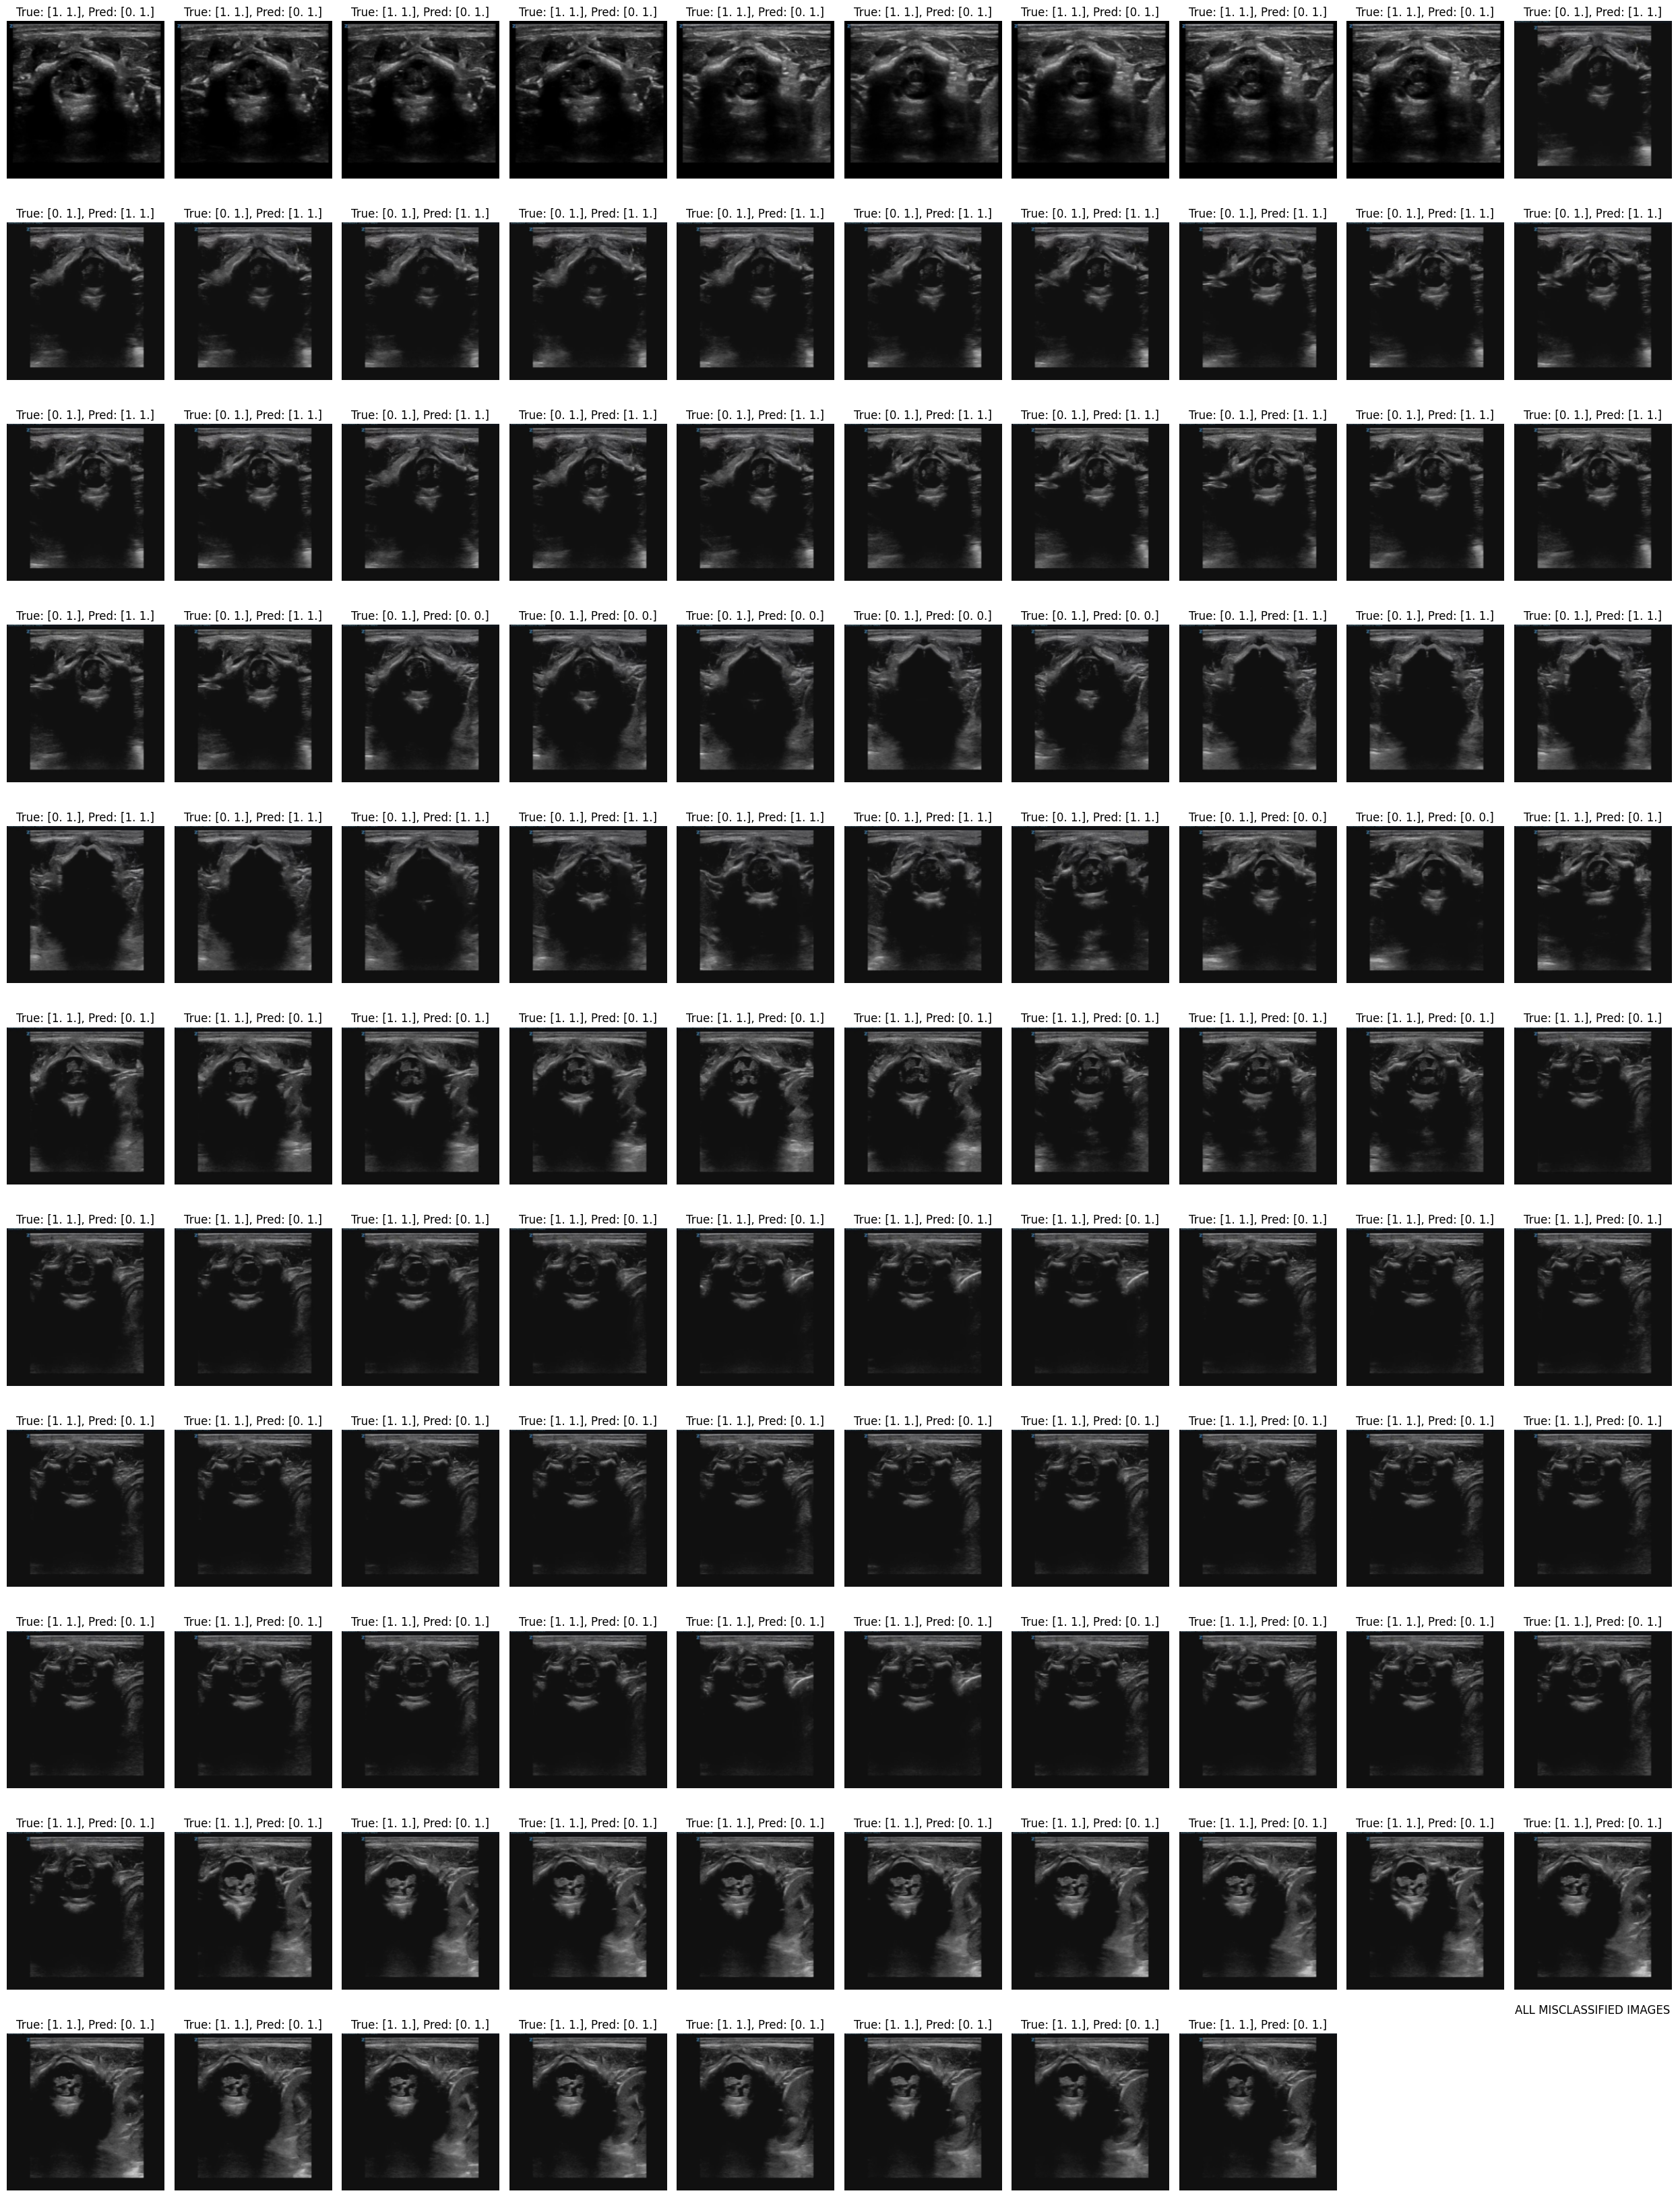

In [28]:
display_misclassified_images(misclassified_images, num_cols=10)